### Using GP prior for regularization of heat MAP not for regression. Note that I never obseve any value. 
This induces coarsening till the lenght scale of the prior.

# KL MULTIVARIATE GAUSSIAN 

The prior is a multivariate Gaussian (GP). 
The covariance matrix is decomposed only once (at the beginning) as cov1 = L1 L1^T by cholesky decomposition
The posterior is a DIAGONAL Normal distribution, therefore cov0 = L0 L0^T = diagonal means that L0 = diag(sigma) 
can be compute at each iteration very cheaply. I have simple analytical expression for the KL_divergence of two multivariate gaussian in terms of mu0, L0, mu1, L1 
Therefore I can frame everyting in the usual VAE framework with KL(posterio|prior) + RECONSTRUCTION

In [ ]:
Implement the KL between two distribution for the special case of posterior (i.e. N0) being diagonal and prior (i.e. N1) being a GP which means that the covariance cna be calculated using the Kernel
<img src="KL_multivariate_gaussian.png">

### IMPORT NECESSARY MODULES

In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import cm

from MODULES.utilities import show_batch
from functools import partial
import torch
import torch.nn.functional as F
from torch.distributions import MultivariateNormal, Normal
import numpy as np
from torchvision import utils
from typing import Optional

def show_batch(images: torch.Tensor,
               n_col: int = 4,
               n_padding: int = 10,
               title: Optional[str] = None,
               pad_value: int = 1):
    """Visualize a torch tensor of shape: (batch x ch x width x height) """
    assert len(images.shape) == 4  # batch, ch, width, height
    if images.device != "cpu":
        images = images.cpu()
    grid = utils.make_grid(images, n_col, n_padding, normalize=True, range=(0.0, 1.0),
                           scale_each=False, pad_value=pad_value)
        
    fig = plt.figure()
    plt.imshow(grid.detach().numpy().transpose((1, 2, 0)))
    if isinstance(title, str):
        plt.title(title)
    plt.close(fig)
    fig.tight_layout()
    return fig

# Example of plotting 3D surfaces

<ipython-input-8-22cfb82d0755>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


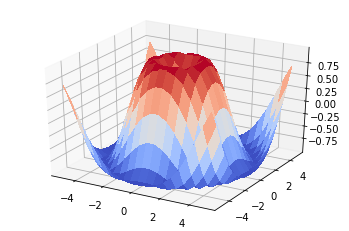

In [8]:
xv, yv = torch.meshgrid([torch.linspace(-5.0,5.0,20), torch.linspace(-5.0,5.0,20)])
zv = torch.sin(torch.sqrt(xv**2 + yv**2))

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xv.numpy(), yv.numpy(), zv.numpy(), cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.show()

# Helper function to draw GP

torch.Size([400])


<ipython-input-9-cdddad39c7d5>:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


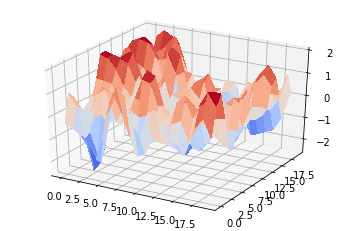

In [9]:
def zero_mean(points):
    """ Input: points.shape = (*, n, D) 
        Output: mu.shape =  (*, n)  
        where batched_dimension * might or might not be present
    """
    independet_dim = points.shape[:-1]
    return torch.zeros(independet_dim, dtype=points.dtype, device=points.device)

def squared_exponential_kernel(points1, points2, length_scale=1.0):
    """ Input:
        points1.shape = (*, n, D)
        points2.shape = (*, m, D)
        Output: 
        C.shape = (*, n, m)
        where batched_dimension * might or might not be present
    """
    dim1 = points1.shape[-1]
    dim2 = points2.shape[-1]
    assert dim1 == dim2
    points1 = points1.unsqueeze(-2)  # *, n, 1, D
    points2 = points2.unsqueeze(-3)  # *, 1, m, D
    d2 = (points1-points2).pow(2).sum(dim=-1)  # *, n, m
    return torch.exp(-d2/length_scale)

def draw_from_GP(points, mean_func, conv_func):
    loc = mean_func(points)
    cov = conv_func(points,points)
    # print("loc ->",loc.shape)  # (*, n)
    # print("cov ->",cov.shape)  # (*, n, n)
    z = MultivariateNormal(loc=loc, covariance_matrix=cov).sample()
    assert z.shape == loc.shape
    return z

# Test
xv, yv = torch.meshgrid([torch.arange(0,20).float(), torch.arange(0,20).float()])
p1 = torch.stack((xv, yv ), dim=-1).view(-1,2)

zv = draw_from_GP(points=p1, 
                  mean_func=zero_mean, 
                  conv_func=partial(squared_exponential_kernel, length_scale=4))
print(zv.shape)
zv = zv.view_as(xv)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xv.numpy(), yv.numpy(), zv.numpy(), cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.show()

# Helper function to compute KL between multivariate Normal

In [10]:
def KL_multivariate_numerical(value, mu0, mu1, cov0, cov1):
    """ Input: value = (*, n) 
               mu0, mu1 = (*, n)
               cov0, cov1 = (*, n, n)
        Output: KL = (*) 
    """  
    L1 = torch.cholesky(cov1)
    L0 = torch.cholesky(cov0)
    log0 = MultivariateNormal(loc=mu0, scale_tril=L0).log_prob(value)
    log1 = MultivariateNormal(loc=mu1, scale_tril=L1).log_prob(value)
    return log0-log1

def KL_multivariate_numerical_average(mu0, mu1, cov0, cov1):
    d = MultivariateNormal(loc=mu0, covariance_matrix=cov0)
    kl_av = 0
    N = 100
    for n in range(N):    
        value = d.sample()    
        kl=KL_multivariate_numerical(value, mu0, mu1, cov0, cov1)    
        kl_av += kl
    return kl_av/N

def KL_multivariate_analytical_stupid(mu0: torch.Tensor,
                                      mu1: torch.Tensor,
                                      cov0: torch.Tensor,
                                      cov1: torch.Tensor):
    """ Input: mu0, mu1 = (*, n)
               cov0, cov1 = (*, n, n)
        Output: KL = (*) 
    """
    assert mu0.shape == mu1.shape  # (*, n)
    assert cov0.shape == cov1.shape  # (*, n, n) 
    n = cov0.shape[-1]
    
    cov1_inverse = torch.inverse(cov1)  # (*, n, n)
    prod = torch.matmul(cov1_inverse,cov0) # (*, n, n)
    diag = torch.diagonal(prod,dim1=-1,dim2=-2) # (*, n)
    trace_term = diag.sum(dim=-1)  # (*)
    #print("trace_term",trace_term.shape, trace_term)
    
    x = (mu1-mu0)  # (*, n)
    M_tmp = torch.matmul(cov1_inverse, x.unsqueeze(-1)) # (*, n, 1) = (*, n, n) (*, n, 1)
    square_term = torch.matmul(x.unsqueeze(-2), M_tmp)[...,0,0]  #  (*, 1, 1) = (*, 1, n) (*, n, 1) 
    #print("square_term",square_term.shape, square_term)
    
    logdet_term = torch.logdet(cov1) - torch.logdet(cov0) # (x)
    #print("logdet_term",logdet_term.shape, logdet_term)
    
    return 0.5*(trace_term + square_term - n + logdet_term)

def KL_multivariate_analytical_smart(mu0: torch.Tensor,
                                     mu1: torch.Tensor,
                                     L_cov0: torch.Tensor,
                                     L_cov1: torch.Tensor):
    assert mu0.shape == mu1.shape  # (*, n)
    assert cov0.shape == cov1.shape  # (*, n, n) 
    n = cov0.shape[-1]
    
    # Tr[cov1^(-1)cov0] = Tr[L L^T] = sum_of_element_wise_square(L) 
    # where L = L1^(-1) L0 -> Solve trilinear problem: L1 L = L0
    L = torch.triangular_solve(L_cov0, A=L_cov1, upper=False, transpose=False, unitriangular=False)[0]  # (*,n,n)
    trace_term = torch.sum(L.pow(2), dim=(-1,-2))  # (*)
    #print("trace_term",trace_term.shape, trace_term)
    
    # x^T conv1^(-1) x = z^T z where z = L1^(-1) x -> solve trilinear problem L1 z = x 
    dmu = (mu0-mu1).unsqueeze(-1)  # (*,n,1)
    z = torch.triangular_solve(dmu, A=L_cov1, upper=False, transpose=False, unitriangular=False)[0]  # (*,n,1)
    # Now z.t*z is the sum over both n_points and dimension
    square_term = z.pow(2).sum(dim=(-1,-2))  # (*)
    #print("square_term",square_term.shape, square_term)
    
    # log[det(cov)]= log[det(L L^T)] = logdet(L) + logdet(L^T) = 2 logdet(L)
    # where logdet casn be computed as the sum of the diagonal elements
    logdet1 = torch.diagonal(L_cov1,dim1=-1,dim2=-2).log().sum(-1)
    logdet0 = torch.diagonal(L_cov0,dim1=-1,dim2=-2).log().sum(-1)
    logdet_term = 2 * (logdet1 - logdet0) # (*)  factor of 2 b/c log[det(L L^T)]= 2 log[det(L)]
    #print("logdet_term",logdet_term.shape, logdet_term)
    
    return 0.5*(trace_term + square_term - n + logdet_term)

# Test

In [11]:
xv, yv = torch.meshgrid([torch.arange(0,20).float(), torch.arange(0,20).float()])
p1 = torch.stack((xv, yv ), dim=-1).view(1,-1,2).double()

k = p1.shape[-1]
mu1 = zero_mean(p1)
mu0 = torch.randn_like(mu1)
cov1 = squared_exponential_kernel(p1, p1, length_scale=4.0)
sigma0 = F.softplus(torch.randn_like(mu1))
L_cov0 = torch.diag_embed(sigma0, dim1=-2, dim2=-1)
cov0 = torch.diag_embed(sigma0.pow(2), dim1=-2, dim2=-1)

print("check ->",(torch.cholesky(cov0) - L_cov0).abs().max())

kl_analytical_stupid = KL_multivariate_analytical_stupid(mu0=mu0, 
                                                         mu1=mu1, 
                                                         cov0=cov0, 
                                                         cov1=cov1)
kl_analytical_smart = KL_multivariate_analytical_smart(mu0=mu0, 
                                                       mu1=mu1, 
                                                       L_cov0=L_cov0, 
                                                       L_cov1=torch.cholesky(cov1))
kl_numerical_average = KL_multivariate_numerical_average(mu0=mu0, 
                                                         mu1=mu1, 
                                                         cov0=cov0, 
                                                         cov1=cov1)

print(kl_analytical_stupid)
print(kl_analytical_smart)
print(kl_numerical_average)

check -> tensor(0., dtype=torch.float64)
tensor([7808653.4931], dtype=torch.float64)
tensor([7808653.4929], dtype=torch.float64)
tensor([7324967.2656], dtype=torch.float64)


# TRAIN UNDER KL

torch.Size([8, 400])


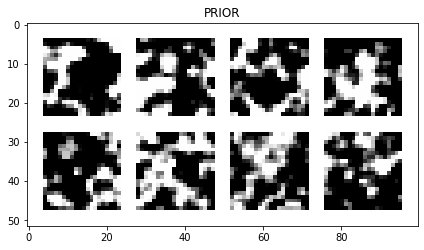

In [14]:
# Create grid
xv, yv = torch.meshgrid([torch.arange(0,20).float(), torch.arange(0,20).float()])
p1 = torch.stack((xv, yv ), dim=-1).view(1,-1,2)

# Sample prior
batch = 8
mu1 = zero_mean(p1)
cov1 = squared_exponential_kernel(p1, p1, length_scale=4.0)
zprior = MultivariateNormal(loc=mu1, covariance_matrix=cov1).expand([8]).sample()
print(zprior.shape)

# reshape to see the results
prior = show_batch(zprior.view([batch,1]+list(xv.shape)), n_col=4, n_padding=4, title="PRIOR")
display(prior)

torch.Size([8, 400])


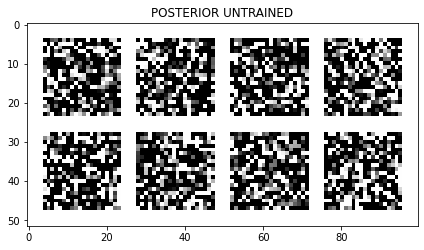

In [15]:
# the posterior is initialized at random
mu0_init = torch.randn_like(zprior).requires_grad_(False)
sigma0_init = F.softplus(torch.randn_like(zprior)).requires_grad_(False)

zposterior_untrained = Normal(loc=mu0_init, scale=sigma0_init).sample()
print(zposterior_untrained.shape)

# reshape to see the results
before = show_batch(zposterior_untrained.view([batch,1]+list(xv.shape)), 
           n_col=4, n_padding=4, title="POSTERIOR UNTRAINED")
display(before)

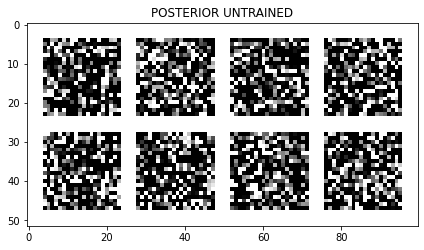

In [16]:
show_batch(mu0_init.view([batch,1]+list(xv.shape)), 
           n_col=4, n_padding=4, title="POSTERIOR UNTRAINED")

In [17]:
L1_prior = torch.cholesky(cov1)
mu0 = mu0_init.clone().requires_grad_(True) 
sigma0 = sigma0_init.clone().requires_grad_(True) 
optimizer = torch.optim.Adam(params=[mu0, sigma0], lr = 1E-3)
print(mu0.shape)
print(mu1.shape)

torch.Size([8, 400])
torch.Size([1, 400])


In [18]:
for epoch in range(10001):
    kl = KL_multivariate_analytical_smart(mu0=mu0, 
                                          mu1=mu1.expand_as(mu0).detach(), 
                                          L_cov0=torch.diag_embed(sigma0, dim1=-2, dim2=-1), 
                                          L_cov1=L1_prior.detach())
    loss = kl.mean()
    if epoch % 100 == 0:
        print(epoch, loss)
    optimizer.zero_grad()
    loss.backward()  
    optimizer.step()

0 tensor(7724976.5000, grad_fn=<MeanBackward0>)
100 tensor(4785251., grad_fn=<MeanBackward0>)
200 tensor(3564206., grad_fn=<MeanBackward0>)


KeyboardInterrupt: 

In [19]:
print(mu0_init[0,:10])
print(mu0[0,:10])
print(sigma0_init[0,:10])
print(sigma0[0,:10])

tensor([-1.0340, -0.3310,  0.6729,  0.6205, -0.5983,  0.8896,  0.0530,  1.3974,
         1.8211, -1.1086])
tensor([-0.8754, -0.4796,  0.8098,  0.4919, -0.4728,  0.7625,  0.1809,  1.2780,
         1.9117, -1.1233], grad_fn=<SliceBackward>)
tensor([0.6999, 1.8491, 1.0902, 0.4597, 1.0587, 0.5912, 0.3260, 0.4736, 1.5299,
        0.7677])
tensor([0.4892, 1.6261, 0.8716, 0.2574, 0.8405, 0.3823, 0.1365, 0.2703, 1.3082,
        0.5539], grad_fn=<SliceBackward>)


In [20]:
z = Normal(loc=mu0, scale=sigma0).sample()
after = show_batch(z.view([batch,1]+list(xv.shape)), n_col=4, n_padding=4, title="AFTER TRAINING")

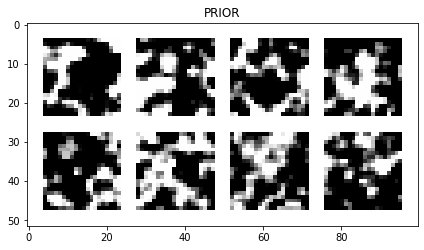

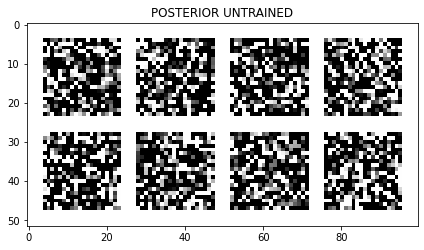

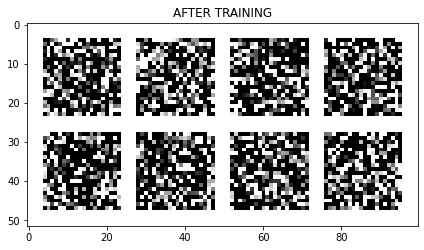

In [21]:
display(prior,before,after)